In [10]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import scipy.optimize as opt
import scipy.spatial

# Kernel definition

In [11]:
def gaussian_kernel(X, Xprime, gamma=2):
    dists = scipy.spatial.distance.cdist(X, Xprime, metric="sqeuclidean")
    return np.exp(-gamma * dists)


def special_kernel(X, Xprime, eta):
    a = eta[0]
    b = eta[1]
    K = (1 + X @ Xprime.T) ** 2 + a * np.multiply.outer(
        np.sin(2 * np.pi * X.reshape(-1) + b),
        np.sin(2 * np.pi * Xprime.reshape(-1) + b),
    )
    return K

In [12]:
# load and normalize Mauna Loa data
data = np.genfromtxt("co2_mm_mlo.csv", delimiter=",")

In [13]:
# 10 years of data for learning
X = data[:120, 2] - 1958
y_raw = data[:120, 3]
y_mean = np.mean(y_raw)
y_std = np.sqrt(np.var(y_raw))
y = (y_raw - y_mean) / y_std
# the next 5 years for prediction
X_predict = data[120:180, 2] - 1958
y_predict = data[120:180, 3]

In [14]:
def negLogLikelihood(params, kernel):
    noise_y = params[0]
    eta = params[1:]

    l = len(X)
    K = kernel(X[:, None], X[:, None], eta) + noise_y * np.eye(l)
    log_deg = np.log(np.linalg.det(K))
    ll = -(
        -0.5 * y.T @ np.linalg.inv(K) @ y
        - 0.5 * log_deg
        - (l / 2) * np.log(np.sqrt(2 * np.pi))
    )

    return ll


def optimize_params(ranges, kernel, Ngrid):
    opt_params = opt.brute(
        lambda params: negLogLikelihood(params, kernel), ranges, Ns=Ngrid, finish=None
    )
    noise_var = opt_params[0]
    eta = opt_params[1:]
    return noise_var, eta


def conditional(X, y, noise_var, eta, kernel):
    l = len(X)
    # See eq. 66 in the lecture notes. Note that there is a small error: Instead of (S) it should be K(S)
    K = kernel(X[:, None], X[:, None], eta)
    K_s = kernel(X[:, None], X_predict[:, None], eta)
    K_ss = kernel(X_predict[:, None], X_predict[:, None], eta)

    G = np.linalg.inv(K + noise_var * np.eye(l))
    alpha = G @ y

    mustar = K_s.T @ alpha
    Sigmastar = K_ss - K_s.T @ G @ K_s

    return mustar, Sigmastar  # return mean and covariance matrix

# Using cholesky decomposition
$ K = LL^T$


In [6]:
def negLogLikelihood_cholesky(params, kernel):
    noise_y = params[0]
    eta = params[1:]

    # Compute the kernel matrix
    K = kernel(X[:, None], X[:, None], eta) + noise_y * np.eye(len(X))

    # Compute log determinant and quadratic term
    L = np.linalg.cholesky(K)
    # alpha = (L^{T})^{-1}) @ (L^{-1} @ y)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    # L being a diagonal matrix has the determinant equal to the sum of the element on the diagonal
    log_det = np.sum(np.log(np.diag(L)))

    # Negative log-likelihood
    nll = 0.5 * np.dot(y.T, alpha) + 0.5 * log_det + 0.5 * len(X) * np.log(2 * np.pi)
    return nll


# Optimize kernel parameters
def optimize_params_cholesky(ranges, kernel, Ngrid):
    opt_params = opt.brute(
        lambda params: negLogLikelihood_cholesky(params, kernel),
        ranges,
        Ns=Ngrid,
        finish=None,
    )
    noise_var = opt_params[0]
    eta = opt_params[1:]
    return noise_var, eta


# # Conditional distribution (posterior mean and covariance)
# def conditional_cholesky(X, y, noise_var, eta, kernel):
#     # Compute kernel matrices
#     K = kernel(X[:, None], X[:, None], eta) + noise_var * np.eye(len(X))
#     K_s = kernel(X[:, None], X_predict[:, None], eta)
#     K_ss = kernel(X_predict[:, None], X_predict[:, None], eta)
#
#     # Compute  decomposition
#     L = np.linalg.cholesky(K)
#     # alpha = (L^{T})^{-1}) @ (L^T @ y)
#     alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
#
#     # Posterior mean
#     mustar = K_s.T @ alpha
#
#     # Posterior covariance
#     v = np.linalg.solve(L, K_s)
#     Sigmastar = K_ss - v.T @ v
#
#     return mustar, Sigmastar

# Viz with Cholesky

optimal params: 1.1112 [2.2223 8.8889]


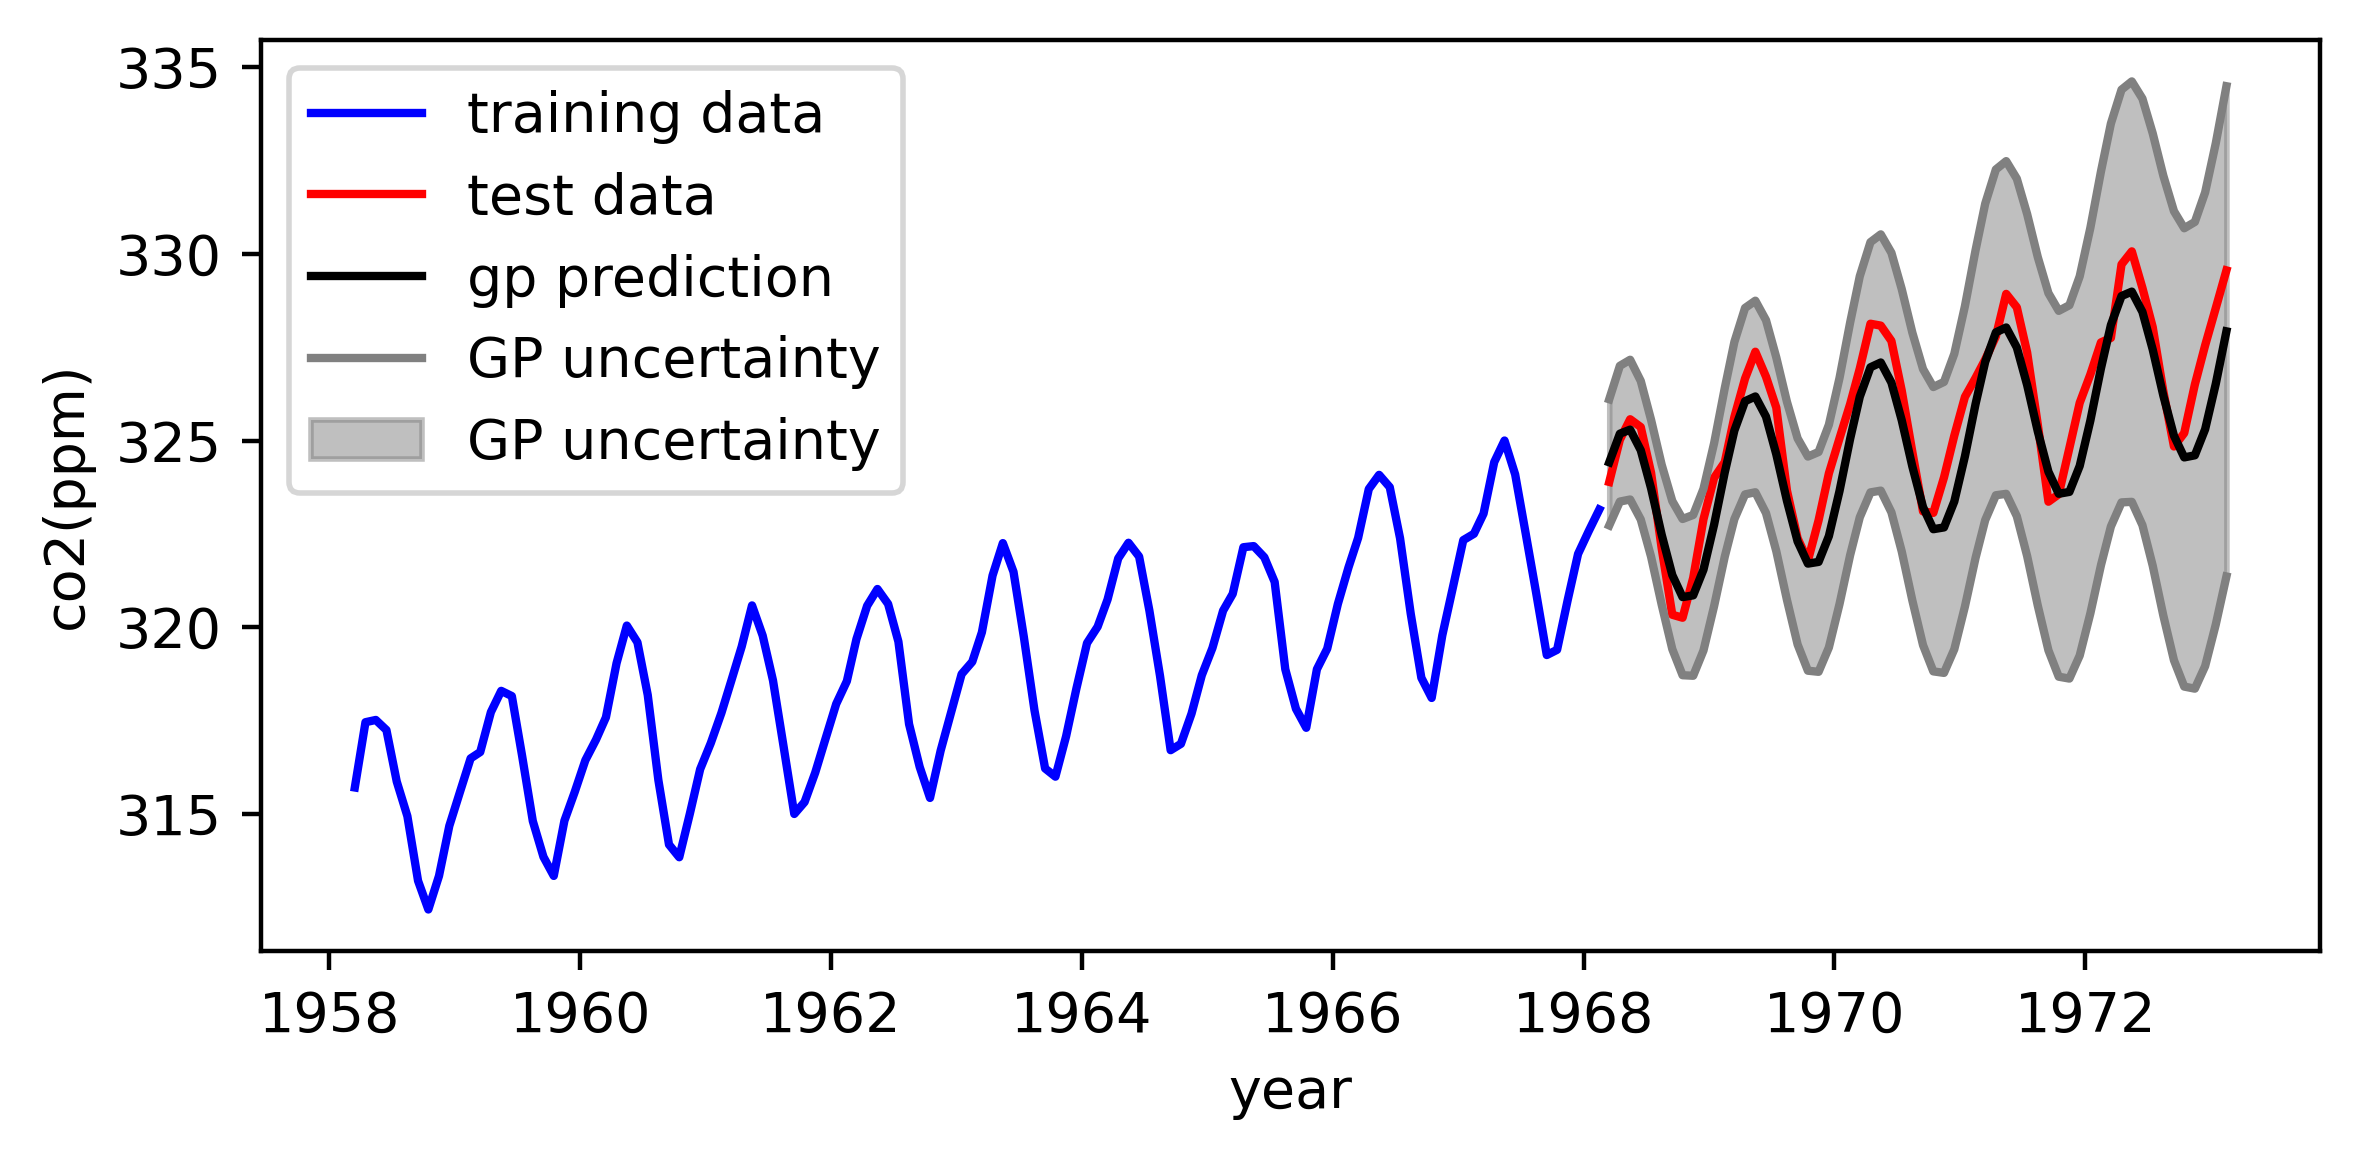

In [16]:
kernel = special_kernel
ranges = ((1.0e-4, 10), (1.0e-4, 10), (1.0e-4, 10))

Ngrid = 10
noise_var, eta = optimize_params_cholesky(ranges, kernel, Ngrid)
print("optimal params:", noise_var, eta)

prediction_mean_gp, Sigma_gp = conditional(X, y, noise_var, eta, kernel)
var_gp = np.diag(
    Sigma_gp
)  # We only need the diagonal term of the covariance matrix for the plots.

# plotting code for your convenience
plt.figure(dpi=400, figsize=(6, 3))
plt.plot(X + 1958, y_raw, color="blue", label="training data")
plt.plot(X_predict + 1958, y_predict, color="red", label="test data")
yout_m = prediction_mean_gp * y_std + y_mean
yout_v = var_gp * y_std**2
plt.plot(X_predict + 1958, yout_m, color="black", label="gp prediction")
plt.plot(
    X_predict + 1958, yout_m + 1.96 * yout_v**0.5, color="grey", label="GP uncertainty"
)
plt.plot(X_predict + 1958, yout_m - 1.96 * yout_v**0.5, color="grey")
plt.fill_between(
    X_predict + 1958,
    yout_m - 1.96 * np.sqrt(yout_v),
    yout_m + 1.96 * np.sqrt(yout_v),
    color="grey",
    alpha=0.5,
    label="GP uncertainty",
)
plt.xlabel("year")
plt.ylabel("co2(ppm)")
plt.legend()
plt.tight_layout()

# Viz without Cholesky

optimal params: 1.0 [1.1112 8.8889]


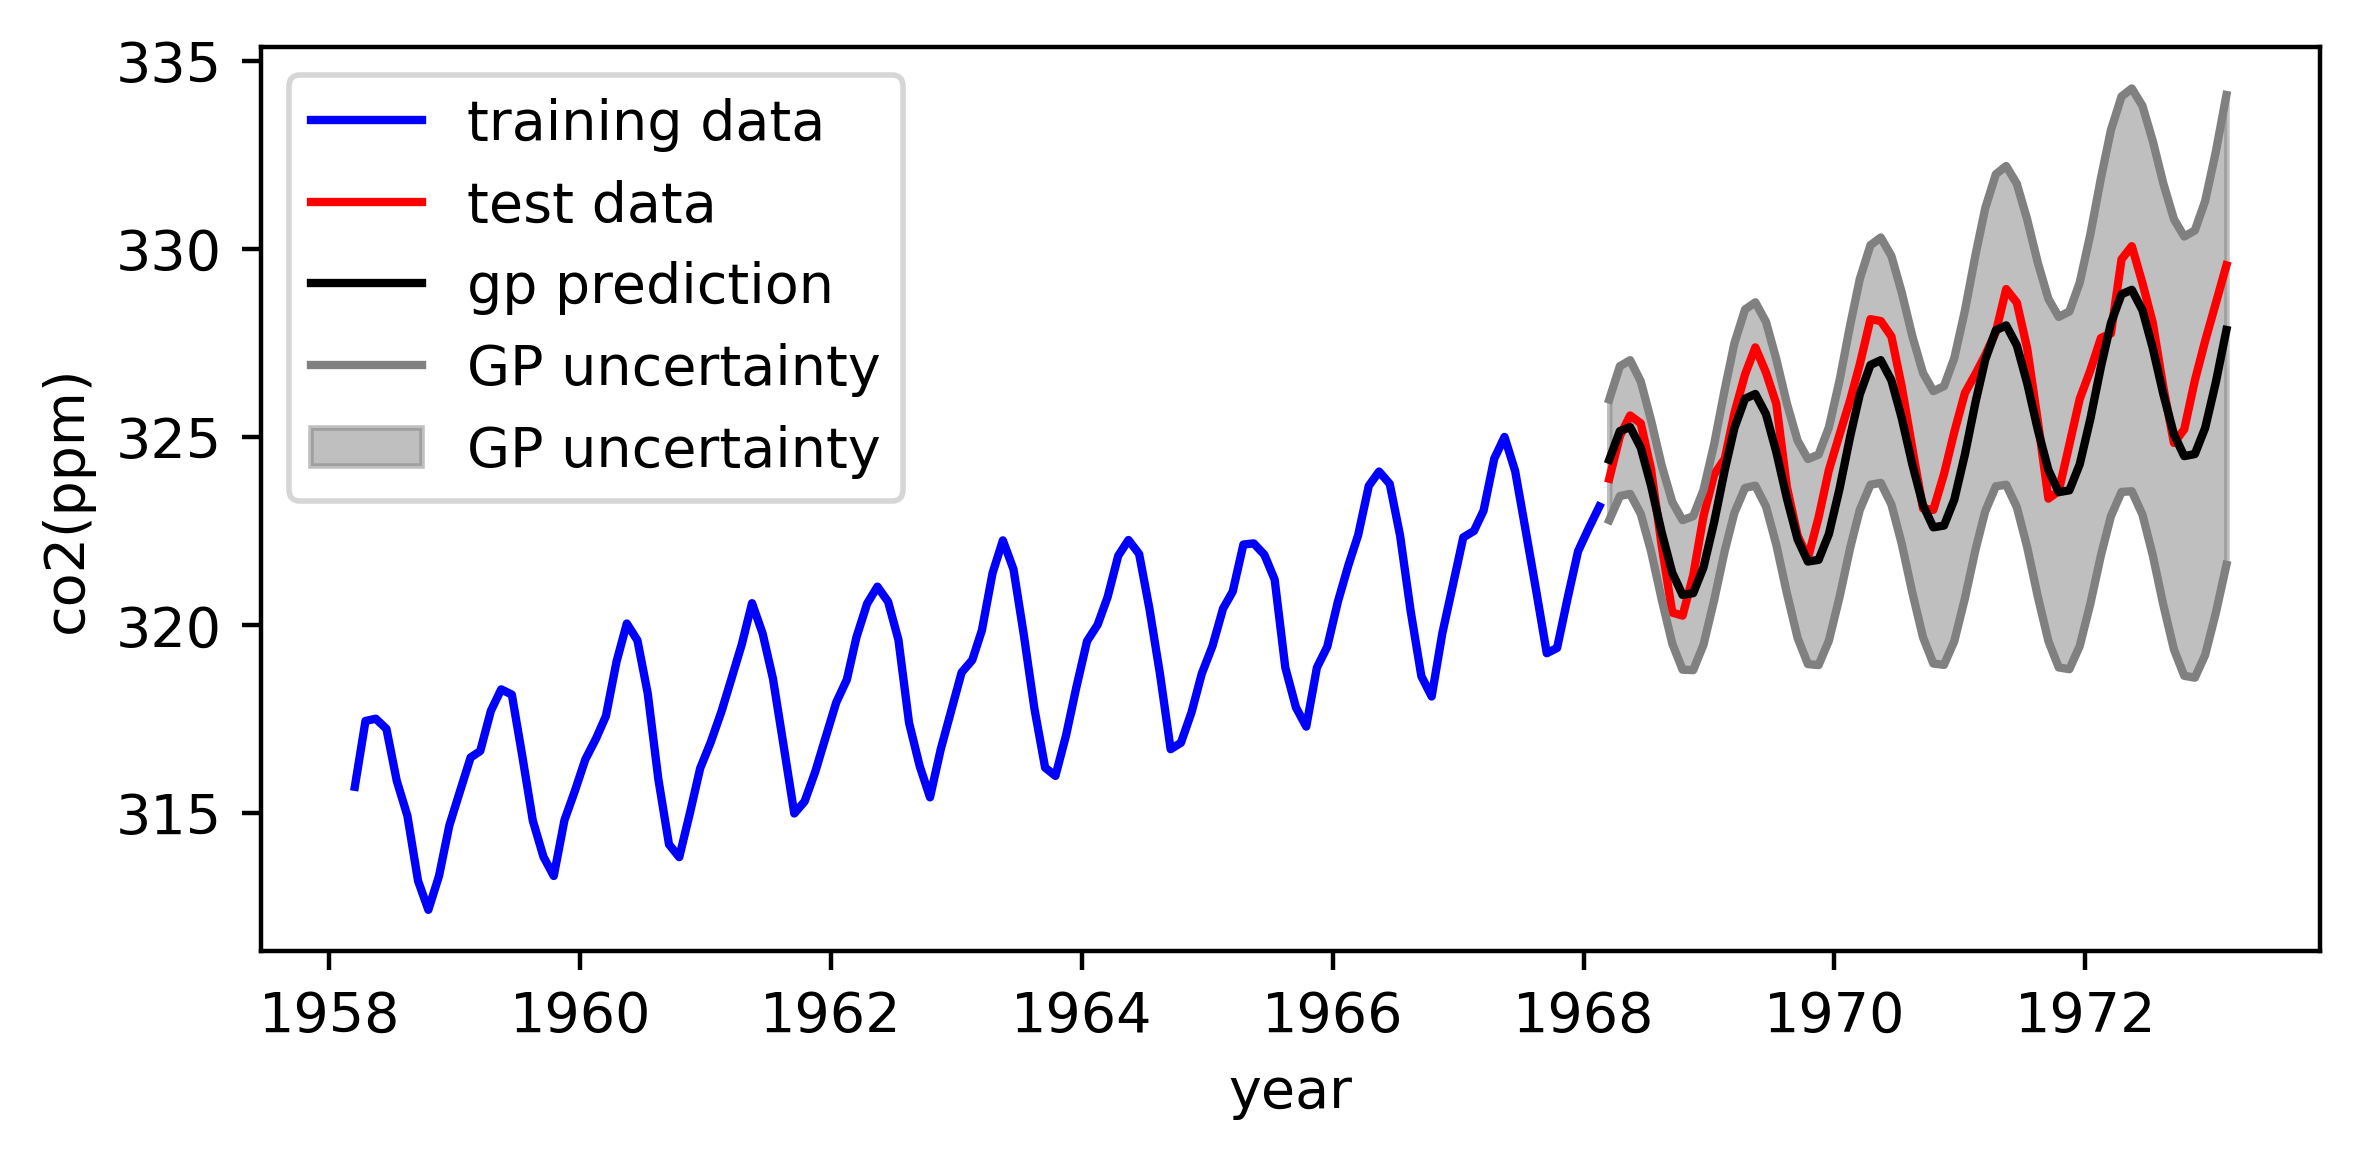

In [19]:
kernel = special_kernel
ranges = ((1, 10), (1.0e-4, 10), (1.0e-4, 10))

Ngrid = 10
noise_var, eta = optimize_params(ranges, kernel, Ngrid)
print("optimal params:", noise_var, eta)

prediction_mean_gp, Sigma_gp = conditional(X, y, noise_var, eta, kernel)
var_gp = np.diag(
    Sigma_gp
)  # We only need the diagonal term of the covariance matrix for the plots.

# plotting code for your convenience
plt.figure(dpi=400, figsize=(6, 3))
plt.plot(X + 1958, y_raw, color="blue", label="training data")
plt.plot(X_predict + 1958, y_predict, color="red", label="test data")
yout_m = prediction_mean_gp * y_std + y_mean
yout_v = var_gp * y_std**2
plt.plot(X_predict + 1958, yout_m, color="black", label="gp prediction")
plt.plot(
    X_predict + 1958, yout_m + 1.96 * yout_v**0.5, color="grey", label="GP uncertainty"
)
plt.plot(X_predict + 1958, yout_m - 1.96 * yout_v**0.5, color="grey")
plt.fill_between(
    X_predict + 1958,
    yout_m - 1.96 * np.sqrt(yout_v),
    yout_m + 1.96 * np.sqrt(yout_v),
    color="grey",
    alpha=0.5,
    label="GP uncertainty",
)
plt.xlabel("year")
plt.ylabel("co2(ppm)")
plt.legend()
plt.tight_layout()